In [146]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
print('packages loaded')

DATA_PATH = './homework_dataset/data_image_stitching/'
print('operating on data from: ', DATA_PATH)


packages loaded
operating on data from:  ./homework_dataset/data_image_stitching/


In [147]:
""" 
generates a list of file directories from a given prefix, number of files, and file type
prefix: prefix of the file name
number_of_files: number of files to read (will be concatenated with the prefix)
file_type: type of the file to read
"""
def generate_test_file_directories(prefix, number_of_files, count_start=0, file_type='jpg'):
    files = []
    for i in range(count_start, (count_start + number_of_files)):
        files.append(DATA_PATH + prefix + str(i) + '.' + file_type)
    return files
        
dirs = generate_test_file_directories('im1_', 2, 1,'png')
print(dirs)
    

['./homework_dataset/data_image_stitching/im1_1.png', './homework_dataset/data_image_stitching/im1_2.png']


In [148]:
"""
generates a list of cv2 images from a list of file directories
files: list of file directories
"""
def generate_cv2_images_from_files(files):
    images = []
    size_of_first_image = cv2.imread(files[0]).shape
    for file in files:
        img = cv2.imread(file)
        resized_img = cv2.resize(img, (size_of_first_image[1], size_of_first_image[0]))
        images.append(resized_img)
    return images

images = generate_cv2_images_from_files(dirs)
print(images[0].shape)
print(images[1].shape)

(799, 1065, 3)
(799, 1065, 3)


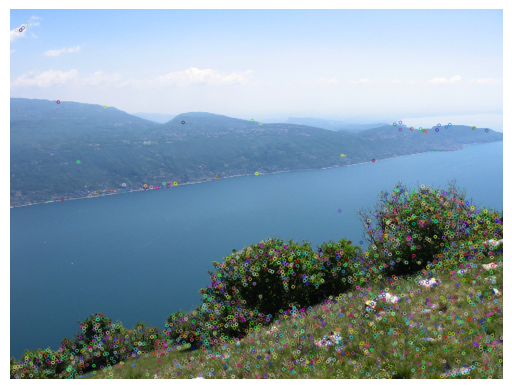

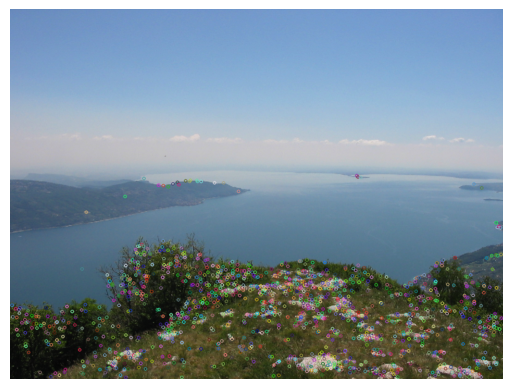

In [149]:
""" 
computes the sift features of a list of images
images: list of images
"""
def compute_sift_features(images):
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        keypoints.append(kp)
        descriptors.append(des)
    return keypoints, descriptors

keypoints, descriptors = compute_sift_features(images)
#display sift features on image
for i in range(len(images)):
    #convert image to rgb
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)
    img = cv2.drawKeypoints(images[i], keypoints[i], None)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    

Finding matches: 100%|██████████| 2649/2649 [00:29<00:00, 90.26it/s]


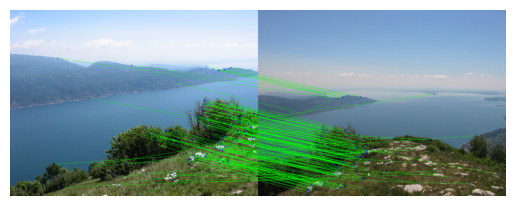

In [150]:
#a function to compute the Euclidean distance between two vectors
def euclidean_distance(v1, v2):
    # Compute and return the Euclidean distance between two vectors
    return np.sqrt(np.sum((v1 - v2)**2))

# Define a function to find the matches between two SIFT descriptors using NNDR
def find_matches(desc1, desc2, threshold):
    # Initialize an empty list to store the matches
    matches = []
    # Loop through each feature in the first descriptor
    for i, f1 in tqdm(enumerate(desc1), total=len(desc1), desc='Finding matches'):
        # Initialize two variables to store the nearest and second nearest distances
        nearest_dist = float('inf')
        second_nearest_dist = float('inf')
        # Initialize a variable to store the index of the nearest feature in the second descriptor
        nearest_index = -1
        # Loop through each feature in the second descriptor
        for j, f2 in enumerate(desc2):
            # Compute the Euclidean distance between the two features
            dist = euclidean_distance(f1, f2)
            # Update the nearest and second nearest distances and index if necessary
            if dist < nearest_dist:
                second_nearest_dist = nearest_dist
                nearest_dist = dist
                nearest_index = j
            elif dist < second_nearest_dist:
                second_nearest_dist = dist
        # Compute the NNDR ratio
        ratio = nearest_dist / second_nearest_dist
        # If the ratio is below the threshold, add the match to the list
        if ratio < threshold:
            matches.append((i, nearest_index))
    # Return the list of matches
    return matches

# Define a method to draw the matched points using cv2
def draw_matches(img1, img2, kp1, kp2, matches):
    # Create a new image to display the matches
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img3 = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    img3[:h1, :w1] = img1
    img3[:h2, w1:] = img2
    # Loop through each match
    for i, j in matches:
        # Get the coordinates of the matched keypoints
        x1, y1 = kp1[i].pt
        x2, y2 = kp2[j].pt
        # Draw a line and a circle for each match
        cv2.line(img3, (int(x1), int(y1)), (int(x2) + w1, int(y2)), (0, 255, 0), 1)
        cv2.circle(img3, (int(x1), int(y1)), 2, (0, 0, 255), -1)
        cv2.circle(img3, (int(x2) + w1, int(y2)), 2, (0, 0, 255), -1)
    # Return the image with the matches
    return img3

desc_1, desc_2 = descriptors[0], descriptors[1]
kp_1, kp_2 = keypoints[0], keypoints[1]
img_1, img_2 = images[0], images[1]
matched_features = find_matches(desc_1, desc_2, 0.8)
matched_features_img = draw_matches(img_1, img_2, kp_1, kp_2, matched_features)
plt.imshow(matched_features_img)
plt.axis('off')
plt.show()

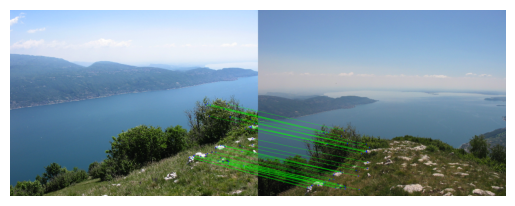

In [151]:
import random
#solving homography using constrained least squares
def compute_homography(src_pts, dst_pts):
    # convert the points to homogeneous coordinates
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    src_pts = np.append(src_pts, np.ones((len(src_pts), 1)), axis=1)
    dst_pts = np.append(dst_pts, np.ones((len(dst_pts), 1)), axis=1)

    # construct the matrix A from the point correspondences
    A = []
    for i in range(len(src_pts)):
        x, y, z = src_pts[i]
        u, v, w = dst_pts[i]
        A.append([0, 0, 0, -w*x, -w*y, -w*z, v*x, v*y, v*z])
        A.append([w*x, w*y, w*z, 0, 0, 0, -u*x, -u*y, -u*z])
    A = np.array(A)

    # compute the singular value decomposition of A
    U, S, V = np.linalg.svd(A)

    # the homography matrix is the last column of V
    H = V[-1].reshape(3, 3)

    # normalize the homography matrix
    H = H / H[2, 2]

    # return the homography matrix
    return H

# Define a function to compute the symmetric transfer error between two sets of points and a homography matrix
def compute_error(p1, p2, H):
    p1 = np.array(p1)
    p2 = np.array(p2)
    
    # convert the points to homogeneous coordinates
    p1 = np.append(p1, np.ones((len(p1), 1)), axis=1)
    p2 = np.append(p2, np.ones((len(p2), 1)), axis=1)
    
    #transform the points from the first image to the second image
    p1_transformed = np.dot(H, p1.T).T
    #normalize the transformed points
    p1_transformed = p1_transformed / p1_transformed[:, 2].reshape(-1, 1)
    
    #transform the points from the second image to the first image
    p2_transformed = np.dot(np.linalg.inv(H), p2.T).T
    #normalize the transformed points
    p2_transformed = p2_transformed / p2_transformed[:, 2].reshape(-1, 1)
    
    #compute the symmetric transfer error
    error = np.sum((p1_transformed[:, :2] - p2[:, :2])**2, axis=1) + np.sum((p2_transformed[:, :2] - p1[:, :2])**2, axis=1)
    
    #return the error
    return error

# Define a function to find the inliers using RANSAC algorithm
def find_inliers(kp1, kp2, matches, threshold, n_iter):
    # Initialize an empty list to store the inliers
    inliers = []
    # Initialize a variable to store the maximum number of inliers
    max_inliers = 0
    # Initialize a variable to store the best homography matrix
    best_H = None
    # Loop through the iterations
    for i in range(n_iter):
        # Randomly select four matches
        sample = random.sample(matches, 4)
        # Get the coordinates of the matched keypoints
        p1 = np.array([kp1[i].pt for i, j in sample])
        p2 = np.array([kp2[j].pt for i, j in sample])
        # Compute the homography matrix using the sample points
        H = compute_homography(p1, p2)
        # Get the coordinates of all the matched keypoints
        p1 = np.array([kp1[i].pt for i, j in matches])
        p2 = np.array([kp2[j].pt for i, j in matches])
        # Compute the error for all the matches
        error = compute_error(p1, p2, H)
        # Find the matches that have error below the threshold
        inliers_i = [match for match, e in zip(matches, error) if e < threshold]
        # Count the number of inliers
        n_inliers = len(inliers_i)
        # Update the inliers, the maximum number of inliers and the best homography matrix if necessary
        if n_inliers > max_inliers:
            inliers = inliers_i
            max_inliers = n_inliers
            best_H = H
    # Return the inliers and the best homography matrix
    return inliers, best_H

inliers, H = find_inliers(kp_1, kp_2, matched_features, 1, 1000)

matched_features_img = draw_matches(img_1, img_2, kp_1, kp_2, inliers)
plt.imshow(matched_features_img)
plt.axis('off')
plt.show()

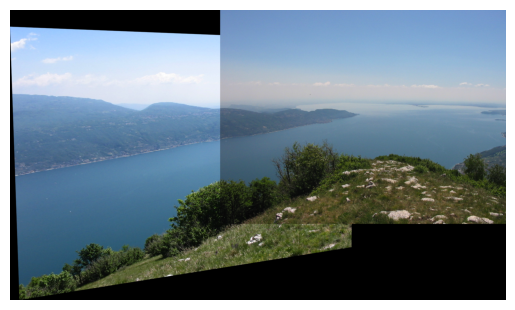

In [152]:
def stitch_images(img1, img2, H, alphas):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    warped_corners2 = cv2.perspectiveTransform(corners1, H)

    corners = np.concatenate((corners1, warped_corners2), axis=0)
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)

    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    warped_img2 = cv2.warpPerspective(img1, Ht @ H, (xmax - xmin, ymax - ymin))
    warped_img2[t[1]:h1 + t[1], t[0]:w1 + t[0]] = img2

    # Alpha blending for seams
    alpha1 = np.ones_like(img1, dtype=np.float32)
    alpha2 = np.ones_like(img2, dtype=np.float32)
    alpha1[:, :] = alphas[0]
    alpha2[:, :] = alphas[1]
    alpha = cv2.warpPerspective(alpha1, Ht @ H, (xmax - xmin, ymax - ymin))
    alpha[t[1]:h1 + t[1], t[0]:w1 + t[0]] = alpha2

    return cv2.normalize((warped_img2 * alpha + warped_img2 * (1 - alpha)).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX)



    
stitched_image = stitch_images(img_1, img_2, H, np.linspace(1, 0, img_1.shape[0]))
plt.imshow(stitched_image)
plt.axis('off')
plt.show()
plt.imsave('stitched_image.jpg', stitched_image)
